# Lab Assignment 4
## Jaskirat Singh Maskeen

Repositories Used:
- [crawl4ai](https://github.com/unclecode/crawl4ai)
- [marker](https://github.com/datalab-to/marker)
- [private-gpt](https://github.com/zylon-ai/private-gpt)

### Imports and Helper Functions

In [ ]:
from pydriller import Repository
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
def process_repository(repo_path: str):
    rows = []
    for idx, (commit, commit_hist) in enumerate(zip(
        Repository(repo_path, skip_whitespaces=True).traverse_commits(),
        Repository(
            repo_path,
            histogram_diff=True,
            skip_whitespaces=True,
        ).traverse_commits(),
    )):
        print(f'Processed {idx+1} commits\r',end='')
        modified_files = commit.modified_files
        modified_files_hist = commit_hist.modified_files
        if len(modified_files) == 0 or len(modified_files_hist) == 0:
            continue

        for mf, mf_hist in zip(modified_files,modified_files_hist):
            rows.append(
                {
                    "old_file_path": mf.new_path,
                    "new_file_path": mf.new_path,
                    "hash": commit.hash,
                    "parents_hash": commit.parents,
                    "message": commit.msg,
                    "diff_myers": mf.diff,
                    "diff_hist": mf_hist.diff,
                    "myers_added_lines": mf.diff_parsed["added"],
                    "myers_deleted_lines": mf.diff_parsed["deleted"],
                    "hist_added_lines": mf_hist.diff_parsed["added"],
                    "hist_deleted_lines": mf_hist.diff_parsed["deleted"],
                }
            )
    print()
    df = pd.DataFrame(rows)
    df.to_csv(f'{repo_path}_commits.csv',index=False)
    return df

In [115]:
def process_discrepency(df, repo_path):
    df["Discrepency"] = (
        df["myers_added_lines"].apply(len) != df["hist_added_lines"].apply(len)
    ) | (df["myers_deleted_lines"].apply(len) != df["hist_deleted_lines"].apply(len))
    df.to_csv(f'{repo_path}_with_discrepency.csv',index=False)
    return df['Discrepency'].value_counts()

In [150]:
def statistics(df):
    md_files_mask = df['new_file_path'].apply(lambda x: False if x == None else x.endswith('.md'))
    license_files_mask = df['new_file_path'].apply(lambda x: False if x == None else x.lower() == 'license')
    tests_files_mask = df['new_file_path'].apply(lambda x: False if x == None else x.startswith('tests\\'))
    source_files_mask = ~(md_files_mask | license_files_mask | tests_files_mask)
    return {
        'md':df[md_files_mask]['Discrepency'].value_counts(),
        'license':df[license_files_mask]['Discrepency'].value_counts(),
        'tests':df[tests_files_mask]['Discrepency'].value_counts(),
        'source':df[source_files_mask]['Discrepency'].value_counts()
    }

In [158]:
def plot(overall_discrepency, discrepency_stats):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    overall_discrepency.plot(
        kind="bar",
        ax=axes[0],
        color=["tab:green", "tab:red"],
        alpha=0.8,
        logy=True
    )
    axes[0].set_title("Overall Discrepancy", fontsize=16)
    axes[0].set_xlabel("Discrepancy", fontsize=12)
    axes[0].set_ylabel("Count (log scale)", fontsize=12)
    axes[0].tick_params(axis="x", rotation=0, labelsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    total = float(sum(overall_discrepency))
    for p in axes[0].patches:
        height = p.get_height()
        if height > 0:
            percentage = f'{(100 * height / total):.1f}%'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            axes[0].annotate(text=percentage, xy=(x, y), ha='center', va='bottom', fontsize=12)
            
    stats_df = pd.DataFrame(discrepency_stats).T.fillna(0).astype(int)

    stats_df.plot(
        kind="bar",
        stacked=False,
        ax=axes[1],
        color=["tab:green", "tab:red"],
        alpha=0.8,
        logy=True
    )
    axes[1].set_title("Discrepancy by File Category", fontsize=16)
    axes[1].set_xlabel("Category", fontsize=12)
    axes[1].set_ylabel("Count (log scale)", fontsize=12)
    axes[1].tick_params(axis="x", rotation=45, labelsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].legend(["Match", "Mismatch"])
    
    category_totals = stats_df.sum(axis=1)
    for container in axes[1].containers:
        labels = []
        for i, bar in enumerate(container):
            height = bar.get_height()
            if height > 0:
                category_name = stats_df.index[i]
                total_for_category = category_totals[category_name]
                if total_for_category > 0:
                    percentage = f'{(100 * height / total_for_category):.1f}%'
                    labels.append(percentage)
                else:
                    labels.append('')
            else:
                labels.append('')
        
        axes[1].bar_label(container, labels=labels, label_type='edge', fontsize=12)


    plt.tight_layout(pad=3.0)
    plt.show()

### Private-gpt

In [161]:
df = process_repository('private-gpt')
sample = df.iloc[:,:7].sample(n=20).head().sort_index()
sample.to_csv(f'private-gpt_sample.csv')
sample

Processed 332 commits


,old_file_path,new_file_path,hash,parents_hash,message,diff_myers,diff_hist
27,constants.py,constants.py,f12ea568e5fe723bfb14d421289f35133d659f6b,[8c6a81a07fc9c800d53f62a33f5ae3b5247a22a6],Use constants.py file,,
427,pyproject.toml,pyproject.toml,224812f7f6a65d5801b6d780c381dde660791523,[adaa00ccc8f8feb704a00623d8b44d7139b73167],Update to gradio 4 and allow upload multiple f...,"@@ -31,7 +31,7 @@ types-pyyaml = ""^6.0.12.12""\...","@@ -31,7 +31,7 @@ types-pyyaml = ""^6.0.12.12""\..."
747,fern\docs\pages\api-reference\sdks.mdx,fern\docs\pages\api-reference\sdks.mdx,d13029a046f6e19e8ee65bef3acd96365c738df2,[9d0d614706581a8bfa57db45f62f84ab23d26f15],feat(docs): add privategpt-ts sdk (#1924),"@@ -8,14 +8,14 @@ The clients are kept up to d...","@@ -8,14 +8,14 @@ The clients are kept up to d..."
823,fern\docs\pages\installation\installation.mdx,fern\docs\pages\installation\installation.mdx,20bad17c9857809158e689e9671402136c1e3d84,[dabf556dae9cb00fe0262270e5138d982585682e],feat(llm): autopull ollama models (#2019)\n\n*...,"@@ -130,16 +130,20 @@ Go to [ollama.ai](https:...","@@ -130,18 +130,22 @@ Go to [ollama.ai](https:..."
950,tests\fixtures\mock_injector.py,tests\fixtures\mock_injector.py,5851b02378313f3dba315e0251cfd421af79dae6,[5fbb402477c41e09f56a3e5adc32f316341772bf],feat: update llama-index + dependencies (#2092...,"@@ -37,6 +37,6 @@ class MockInjector:\n ...","@@ -37,6 +37,6 @@ class MockInjector:\n ..."


In [162]:
overall_discrepency = process_discrepency(df,'private-gpt')
overall_discrepency

Discrepency
False    938
True      16
Name: count, dtype: int64

In [163]:
discrepency_stats =statistics(df)
discrepency_stats

{'md': Discrepency
 False    74
 True      3
 Name: count, dtype: int64,
 'license': Discrepency
 False    2
 Name: count, dtype: int64,
 'tests': Discrepency
 False    43
 Name: count, dtype: int64,
 'source': Discrepency
 False    819
 True      13
 Name: count, dtype: int64}

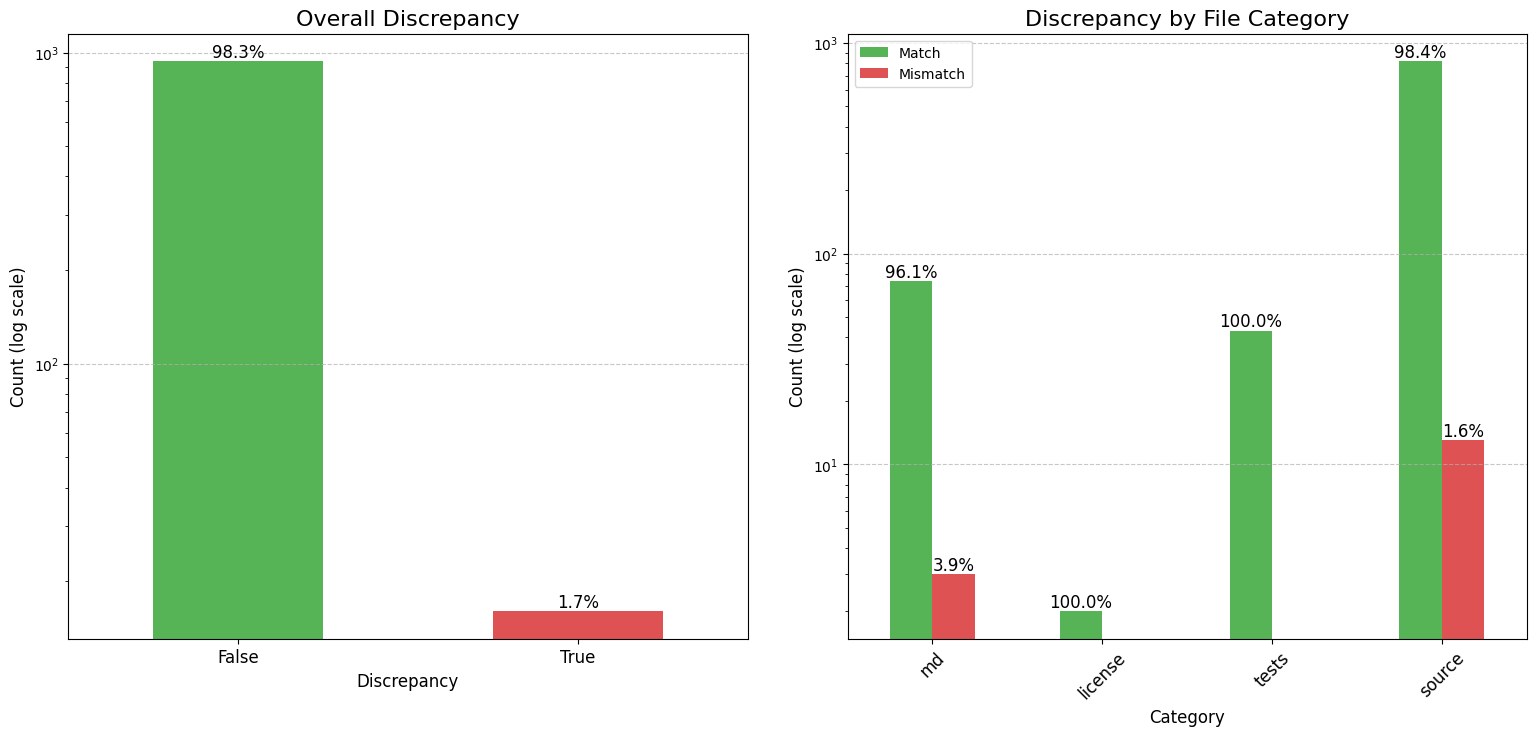

In [164]:
plot(overall_discrepency,discrepency_stats)

### Crawl4ai

In [165]:
df = process_repository('crawl4ai')
sample = df.iloc[:,:7].sample(n=20).head().sort_index()
sample.to_csv(f'crawl4ai_sample.csv')
sample

Processed 1035 commits


,old_file_path,new_file_path,hash,parents_hash,message,diff_myers,diff_hist
877,docs\md_v1\changelog.md,docs\md_v1\changelog.md,4239654722647f90bf2ab5cb3095cc02e40b4a7a,[38474bd66ac4c1f31acd9c6c64498c3fe51f7c27],Update Documentation,,
1099,main_v0.py,main_v0.py,c4c62279629795a4a1e9568e0bbe027d8c8a3a95,[e6c914d2fa44478f34298a464b58577f33e9916b],Creating the API server component,"@@ -0,0 +1,254 @@\n+import os\n+import importl...","@@ -0,0 +1,254 @@\n+import os\n+import importl..."
1497,a.md,a.md,0982c639aee0ab6f8517cd9aecd7a99ef62fa051,[5188b7a6a058f6cfe9686a2b98ebad10018f7a5d],Enhance AsyncWebCrawler and related configurat...,"@@ -0,0 +1,4214 @@\n+diff --git a/.gitignore b...","@@ -0,0 +1,4214 @@\n+diff --git a/.gitignore b..."
1606,docs\llm.txt\guides\22_tutorial_dynamic_clicks.md,docs\llm.txt\guides\22_tutorial_dynamic_clicks.md,84b311760f5a0f96a1614604fe7e9fc5a7c7197f,[8fbc2e0463d39b22b0bf438e19795596cc468383],Commit Message:\n Enhance Crawl4AI with CLI a...,"@@ -0,0 +1,117 @@\n+# Tutorial: Clicking Butto...","@@ -0,0 +1,117 @@\n+# Tutorial: Clicking Butto..."
3045,None,None,b1693b1c215bc7c7bbf9379e9e311a6f843d9dc3,[14894b4d7033d619ef616f8b6cae19e896dd6a64],Remove old quickstart files,"@@ -1,675 +0,0 @@\n-import os, sys\n-\n-from c...","@@ -1,675 +0,0 @@\n-import os, sys\n-\n-from c..."


In [166]:
overall_discrepency = process_discrepency(df,'crawl4ai')
overall_discrepency

Discrepency
False    4056
True      135
Name: count, dtype: int64

In [167]:
discrepency_stats =statistics(df)
discrepency_stats

{'md': Discrepency
 False    1015
 True       56
 Name: count, dtype: int64,
 'license': Discrepency
 False    2
 Name: count, dtype: int64,
 'tests': Discrepency
 False    236
 True       2
 Name: count, dtype: int64,
 'source': Discrepency
 False    2804
 True       77
 Name: count, dtype: int64}

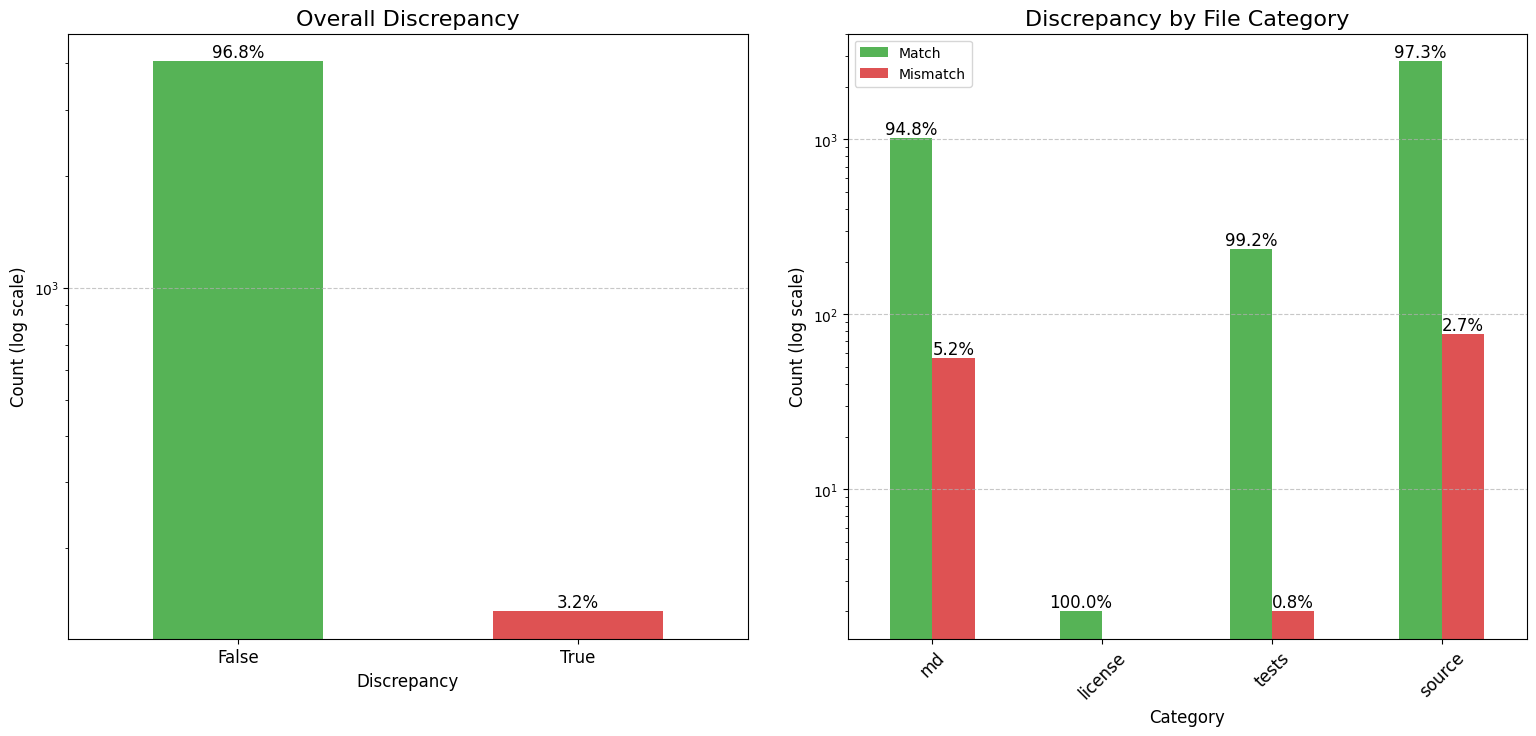

In [168]:
plot(overall_discrepency,discrepency_stats)

### Marker

In [169]:
df = process_repository('marker')
sample = df.iloc[:,:7].sample(n=20).head().sort_index()
sample.to_csv(f'marker_sample.csv')
sample

Processed 1215 commits


,old_file_path,new_file_path,hash,parents_hash,message,diff_myers,diff_hist
1218,marker\v2\builders\structure.py,marker\v2\builders\structure.py,4386612de4479edf60f2beeb2ed20b5b65a02b0a,[d6d8387afd5b31acaae74dd06f7cef57facdf8cb],"Fix structure, change blockid to class","@@ -16,37 +16,36 @@ class StructureBuilder(Bas...","@@ -16,37 +16,36 @@ class StructureBuilder(Bas..."
2633,marker\providers\registry.py,marker\providers\registry.py,5ef415564f681d3651e8348ba48d9cce5b21e177,[8448dd8035ee2b00bb2c4c7d43076cb3c19c245a],Add image provider and tests,"@@ -0,0 +1,12 @@\n+import filetype\n+\n+from m...","@@ -0,0 +1,12 @@\n+import filetype\n+\n+from m..."
3064,marker\scripts\convert.py,marker\scripts\convert.py,727a475147224d3b25bc6310182d06ceff868f95,[ac8b59335f80da457a506f4230d604063a672115],Clean up config parsing,"@@ -63,12 +63,12 @@ def process_single_pdf(arg...","@@ -63,12 +63,12 @@ def process_single_pdf(arg..."
3484,marker\processors\table.py,marker\processors\table.py,78a14bbaa1cfae5c7ca7fdc849ce2295a0899dfc,[5d28d39cba35773a0e31dd9d7282cfc40c3cfa9f],OCR irregular docs,"@@ -12,8 +12,6 @@ from surya.table_rec.schema ...","@@ -12,8 +12,6 @@ from surya.table_rec.schema ..."
4240,README.md,README.md,b6cfc64b9f8679e4090a00abbca0904dcb3e278b,[1b60ed5bc21c2eb660fb5fe2941b21d1e6d3fc91],Remove format lines option,"@@ -80,8 +80,8 @@ pip install marker-pdf[full]...","@@ -80,8 +80,8 @@ pip install marker-pdf[full]..."


In [170]:
overall_discrepency = process_discrepency(df,'marker')
overall_discrepency

Discrepency
False    4206
True       89
Name: count, dtype: int64

In [171]:
discrepency_stats =statistics(df)
discrepency_stats

{'md': Discrepency
 False    142
 True      15
 Name: count, dtype: int64,
 'license': Discrepency
 False    2
 Name: count, dtype: int64,
 'tests': Discrepency
 False    274
 True       2
 Name: count, dtype: int64,
 'source': Discrepency
 False    3791
 True       73
 Name: count, dtype: int64}

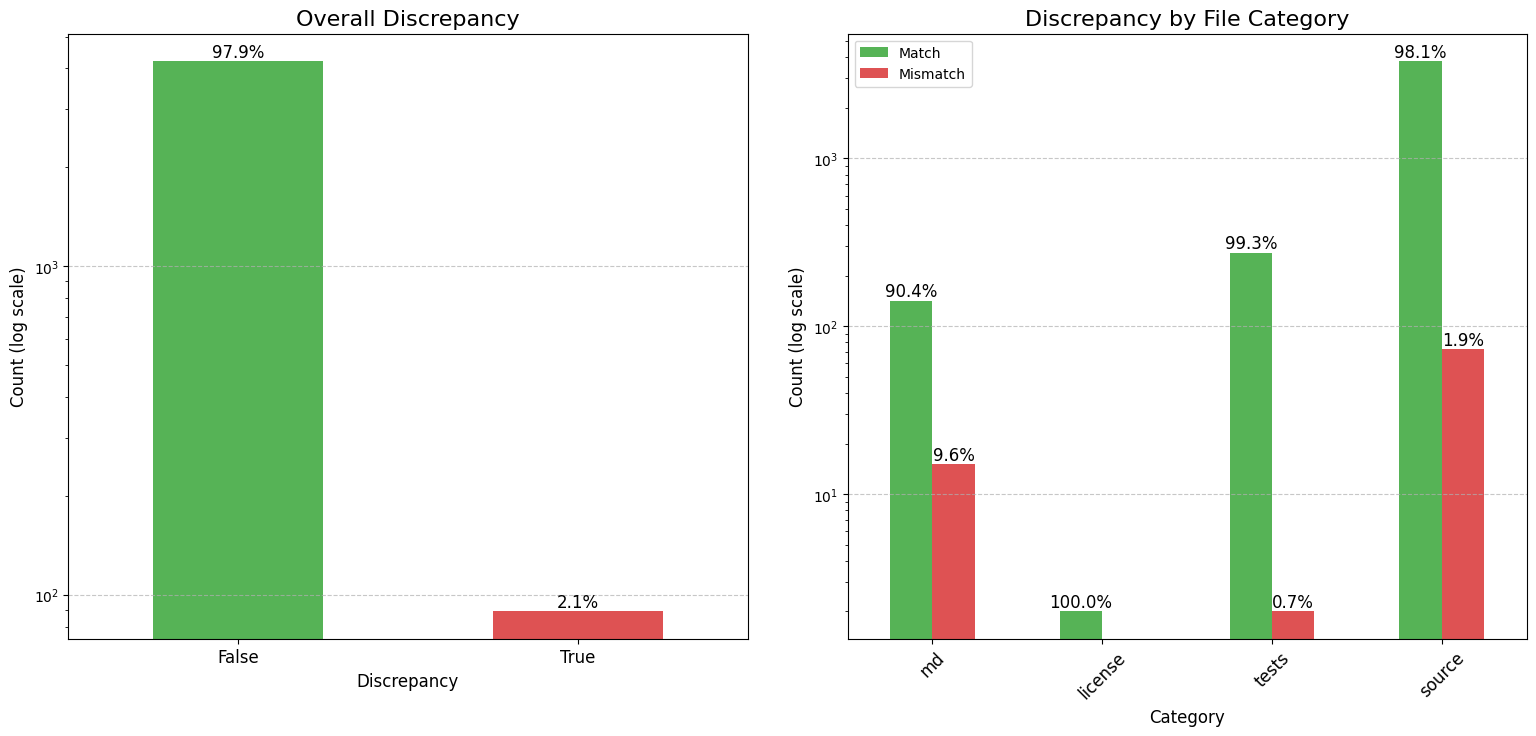

In [172]:
plot(overall_discrepency,discrepency_stats)